# Linear Regression (predictions from continuous data)

<i>By Diego Ramallo</i>

Here we'll try out a linear regression exercise on our own. This exercise will cover basic linear regression, ridge regression/lasso regression, and gradient descent. It will also include error determination, and cross-validation techniques. We will be following this template: http://facweb.cs.depaul.edu/mobasher/classes/csc478/Notes/IPython%20Notebook%20-%20Regression.html

## Understanding and organizing our data

In [58]:
#We'll import our sklearn model libraries
from sklearn.cross_validation import KFold, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
#Here we'll import our data from the sklearn library
from sklearn.datasets import load_boston

boston= load_boston()

In [60]:
#boston seems to be a dictionary, let's check the keys
#to see what kind of data we're working with
boston.keys()

['data', 'feature_names', 'DESCR', 'target']

In [61]:
#Great, we can see the relevant items for our machine learning
#tasks. Let's take data, target, and feature names
#and put them into a dataframe for easier viewing
bostonDF = pd.DataFrame(boston['data'], columns= boston['feature_names'])
bostonDF['target'] = boston['target']

In [62]:
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Great now we have a dataframe with all of our features and labels on the same data structure. In our tutorial we are directed to add an extra row of ones to do multiple regression. Let's do that for now as well. 

In [63]:
bostonDF['x0']= np.array(np.ones(len(bostonDF['target'])))#Using length of target as ref to make correct length x0 column

In [64]:
#Let's get a look at some of our data
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,x0
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,1.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,1.0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,1.0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,1.0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,1.0


In [65]:
#Now let's get a description of our dataset
bostonDF.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,x0
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.0
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806,1.0
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104,0.0
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000,1.0
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000,1.0
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000,1.0
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000,1.0
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,1.0


## Splitting our datasets

In [66]:
#Now we'll split our data first into training/testing (wel'll further divide testing into validation, real test)
train, rest= train_test_split(bostonDF, test_size= 0.5, random_state= 42)#random_state sets seed
#If I had features/labels on different arrays say a= feature data and b = labe/response we'd use the following
#aTraining,bTraining, aTesting, bTesting = train_test_split(a, b, test_size= 0.25, random_state= 42)

In [67]:
#Now we'll split this further into validation and testing datasets
valid, test = train_test_split(rest, test_size = 0.5, random_state= 42)

#Verify that the lenths of our datasets are about 50/25/25 for train/valid/test
print len(train), len(valid), len(test)

253 126 127


## Implementing a basic regression model

Before implementing the model, it's important to mention that to initially weigh all of our features equally we need to <strong>standardize/scale</strong> them. SKLearn has a module for scaling (preprocessing.scale) so notice that during most of my fits I'll be applying this operation to our dataframes.

In [68]:
#We'll start with linear regression before optimization
linReg0= LinearRegression()

In [69]:
#Now we'll fit our data using our features (all cols but 'target') and our response ('target')
from sklearn import preprocessing
linReg0.fit(preprocessing.scale(train.ix[:, train.columns != 'target']), train['target'])# First argument selects everything but target column

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
#Now that' we have model, we can predict values using our validation set features

predVal= linReg0.predict(preprocessing.scale(valid.ix[:, train.columns != 'target']))

In [14]:
#Now we can calculate our error 

absErr = abs(predVal-valid['target'])
MSE= sum(absErr**2)/len(predVal)
rootMSE= np.sqrt(MSE)
#Could also take the dot product of
#error with itself to give us the sum of squared errors, try next lines

#new= np.dot(absErr,absErr)
#np.sqrt(new/len(predVal))

#Let's also look at the median value for the true values
print 'The median value for our target values is: ', np.median(valid['target'])

print 'The MSE and RMSE error metrics for the validation set are \n MSE: %s \n RMSE: %s '% (MSE,rootMSE)#Could also use .format() for format strings

The median value for our target values is:  20.95
The MSE and RMSE error metrics for the validation set are 
 MSE: 19.4357976595 
 RMSE: 4.40860495616 


Thus, our error (from RMSE) is about 20% of our target value. We can explore this further by visualizing our true vs predicted values and our residual plot.

<IPython.core.display.Javascript object>


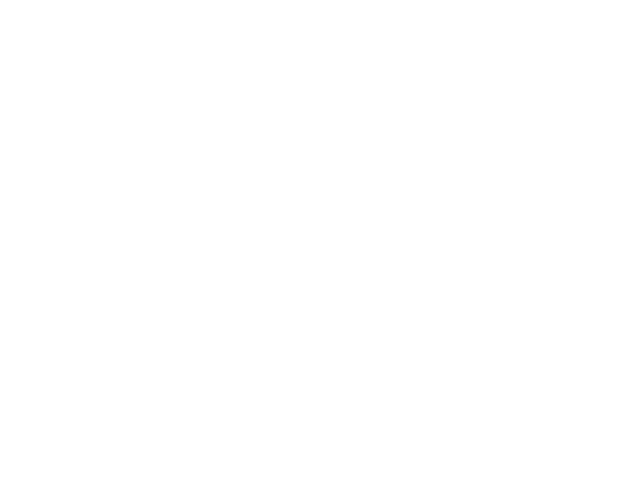

In [15]:
#We can plot the results of the predictions against the real values
#Good predictions should show a linear relationship with true values
%matplotlib nbagg

plt.subplot(1,2,1)
plt.plot(predVal, valid['target'], '.')
plt.plot(range(0,50),range(0,50), '-')#Plots ideal reference where y=x
plt.xlabel('Predicted target value')
plt.ylabel('True target value')
plt.title('True vs Predicted')

#Additionally, a residuals (predicted-true response) plot will tell us how far our predictions
#were from our validation responses

plt.subplot(1,2,2)
plt.plot(valid['target'], predVal-valid['target'], '.r')
plt.plot(valid['target'], np.zeros(len(valid['target'])), 'k-')
plt.xlabel('True target value')
plt.ylabel('Residuals')
plt.title('Residual Plot')

In [16]:
#Let's calculate the R-squared value 
import scipy
_, _, r_value, _, _ = scipy.stats.linregress(predVal, valid['target'])
print 'R-squared value: ', r_value**2#Squares r-value

R-squared value:  0.749433286209


As you can see from the 'True vs Predicted' plot, we only really get values close to the True target values near the center of our target range. Our R-squared score of 0.75 also shows a weaker correlation than we'd like (something closer to 1.0 would be preferable). Our 'Residual Plot' confirms this by showing that the difference between our predicted and true values can be quite large at times. <strong>Thus, our model could probably be improved by optimization steps</strong>.

## K-Fold Cross-Validation

Now we'll test the performance of our linear regression by training on different randomized subsets of our combined training and validation sets. 

In [17]:
#Ok first we'll append the validation data to our train data to further resplit with kfold
train2= train.append(valid)
print len(train), len(valid), len(train2)
train2.head(3)

253 126 379


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,x0
475,6.39312,0.0,18.10,0.0,0.584,6.162,97.4,2.2060,24.0,666.0,20.2,302.76,24.10,13.3,1.0
299,0.05561,70.0,2.24,0.0,0.400,7.041,10.0,7.8278,5.0,358.0,14.8,371.58,4.74,29.0,1.0
296,0.05372,0.0,13.92,0.0,0.437,6.549,51.0,5.9604,4.0,289.0,16.0,392.85,7.39,27.1,1.0


In [55]:
#Note: we're working with pandas indices but these were shuffled up at the beginning,
#they don't match the indices that our KFold object utilizes. Better to turn them into a numpy array first
train2X= preprocessing.scale(train.ix[:, train.columns != 'target'])
train2Y= train['target'].as_matrix()

In [19]:
#Now we'll use these arrays to define the K-Fold splits. The number determines the amount of
#bias and variance you'd like in your predictions. Typically, larger folds is better if you have 
#enough samples. Since we have less tha 500 here, I'll keep it at 5 (3, 5, and 10 is common)

kf= KFold(len(train2X), n_folds= 5, shuffle= False, random_state= 42)
kf

sklearn.cross_validation.KFold(n=253, n_folds=5, shuffle=False, random_state=42)

In [20]:
#Now we'll apply the same error estimation that we did before to each split
rmseList= []#Initialize list to hold rmse scores

#Apply linear regression to each fold, predict and calculate RMSE
for trainKF, testKF in kf:
    #Train on a subset of training/val set using the training indices of different folds
    linReg0= LinearRegression()
    linReg0.fit(train2X[trainKF], train2Y[trainKF])#Scaled already don't need to do it again
    
    #Predict on a subset of data using the testing indices
    predKF= linReg0.predict(train2X[testKF])
    
    #Calculate error from predicted values and testing indices
    kfError= predKF-train2Y[testKF]#These indices may not make sense cause we
    
    #Calculate the RMSE and append to our list of RMSE's
    #rmseKF=  np.sqrt(np.mean(kfError**2))
    rmseKF= np.sqrt(np.dot(kfError,kfError)/len(predKF))
    print 'RMSE: ', rmseKF
    rmseList.append(rmseKF)
rmseAverageKF= np.mean(rmseList)
print 'Our mean RMSE from K-Fold validation is: ', rmseAverageKF

RMSE:  4.31238328774
RMSE:  5.17322711483
RMSE:  4.56427022412
RMSE:  4.61976867615
RMSE:  5.32818021194
Our mean RMSE from K-Fold validation is:  4.79956590296


In [21]:
#This just shows that the dot product of error equals sum of square diff's
print np.dot(kfError,kfError)
print sum((predKF-train2Y[testKF])**2)

1419.47521854
1419.47521854


In [22]:
#Let's compare this to what we got by training on the train set and testing on the validation set
print 'RMSE single fold: ', rootMSE
print 'RMSE k-fold: ', rmseAverageKF

RMSE single fold:  4.40860495616
RMSE k-fold:  4.79956590296


Excellent! So our RMSE went down :) Let's see how much we can improve this by reducing the variance with regularization: L1 (Lasso) regression, and L2 (Ridge) regression methods. 

## Feature Selection 

<strong>Ridge Regression (L2)</strong>

Just as an overview, Ridge Regression adds an extra term to our RSS equation that adds additional coefficient estimates. As our tuning parameter <i>alpha</i> increases, the value of the coefficients approach zero. When <i>alpha</i> is large, the coefficients approach 0. Also, <i>alpha</i> does not affect the intercept coefficient (typically beta-0). 

An <i>alpha</i> of zero will yield betas of the same value of linear regression with high variance and low bias, and as <i>alpha</i> grows, it will result in a decrease in variance and higher bias. Finally, Ridge typically performs better when you expect that the coefficients are of similar magnitude. 

Since we don't know what our optimal <i>alpha</i> value will be, we'll need to test a bunch of values across different size scales and find which one is optimal. Luckily, SKLearn has a version of Ridge (RidgeCV) that includes cross-validation that will allow us to do that. We'll just need to set number of alphas (numAlphas) to try and the range (alphaList) that they'll cover first.

In [41]:
from sklearn import linear_model
#Now let's set the number of alphas we'll test along with its range
numAlphas= 100
alphaList= np.logspace(-10,10,numAlphas)
ridge0= linear_model.RidgeCV(alphas= alphaList)
ridge0.fit(train2X, train2Y)#Scaled already don't need to do it again

print 'Your optimal alpha is: ', ridge0.alpha_

Your optimal alpha is:  8.1113083079


Now let's implement this on our testing set to get an out of sample accuracy score.

In [42]:
#First train on your training set again using the optimal alpha

ridgeFinal= linear_model.Ridge (alpha = ridge0.alpha_)
ridgeFinal.fit(train2X, train2Y)

Ridge(alpha=8.1113083078968558, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [25]:
#Now preprocess our features for our test set, and predict

predValRidge= ridgeFinal.predict(preprocessing.scale(test.ix[:, test.columns != 'target']))

In [26]:
plt.scatter(test['target'], predValRidge)

In [27]:
ridgeRMSE= np.sqrt(sum((predValRidge-test['target'])**2)/len(predValRidge))
ridgeRMSE

5.7021843080900387

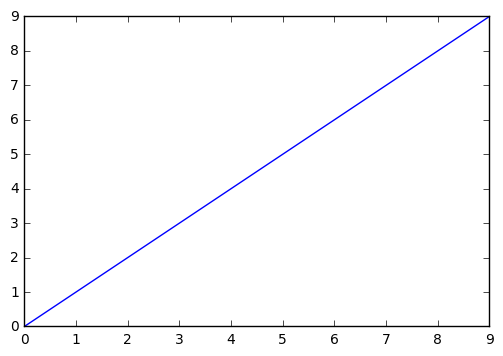

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(10),range(10))

In [29]:
import .statsplots
import numpy as np
list1= [1,2,3,4,5,2,5,3,2,42,5,2,4,5,3]
dg.cdfPlot(list1)

SyntaxError: invalid syntax (<ipython-input-29-88405f888620>, line 1)

In [ ]:
*If I use 

## Principal Component Regression (PCA + Linear Regression)

## Random Forest

In [71]:
train2X

array([[ 0.36480028, -0.51555608,  0.98572244, ..., -0.54400037,
         1.62849278,  0.        ],
       [-0.40938646,  2.42360314, -1.26202295, ...,  0.1829827 ,
        -1.10236752,  0.        ],
       [-0.40961735, -0.51555608,  0.39331539, ...,  0.40766928,
        -0.72856691,  0.        ],
       ..., 
       [-0.41434614,  2.84348303, -1.29461951, ...,  0.38749291,
        -0.92604648,  0.        ],
       [ 0.94716859, -0.51555608,  0.98572244, ..., -2.58181356,
         1.51141561,  0.        ],
       [-0.38823456, -0.51555608, -0.36632618, ..., -2.99431994,
        -0.27154277,  0.        ]])

In [85]:
#Sometimes we get these errors from converting a dataframe to an array. The np.asarray command should fix this
from sklearn.ensemble import RandomForestClassifier

randfor= RandomForestClassifier(n_estimators= 100)
forfit= randfor.fit(preprocessing.scale(train.ix[:, train.columns != 'target']), np.asarray(train['target'], dtype="|S6"))
forpred= forfit.predict(preprocessing.scale(test.ix[:, test.columns != 'target']))

In [87]:
#Now let's get the list of variable importance from our fit. Larger numbers = greater importance
importances = randfor.feature_importances_

In [92]:
importanceDF= pd.DataFrame()
importanceDF['features']= test.ix[:, test.columns != 'target'].columns
importanceDF['importance']= importances
importanceDF

,features,importance
0,CRIM,0.120444
1,ZN,0.023059
2,INDUS,0.054061
3,CHAS,0.011976
4,NOX,0.080589
5,RM,0.128715
6,AGE,0.111367
7,DIS,0.105385
8,RAD,0.039760
9,TAX,0.054413


In [105]:
rankImportance= importanceDF.sort_values(by='importance', ascending= False)

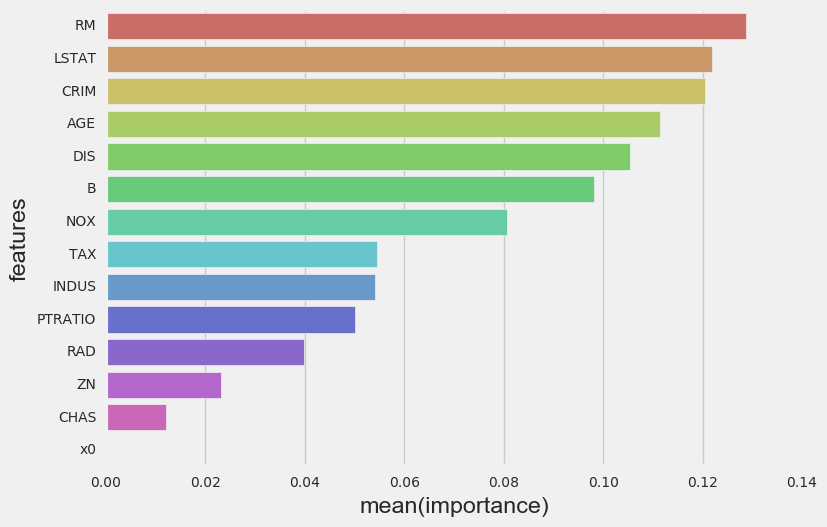

In [112]:
import seaborn as sns
sns.barplot(y="features", x="importance", data=rankImportance, palette= 'hls')